# Homework Assignment3

In [74]:
import cv2
import scipy
import numpy as np
from PIL import Image
import scipy.sparse.linalg
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import os
os.makedirs("results", exist_ok=True)

In [2]:
# util function
def upper_left_background_rc(object_mask, bottom_center):
    ys, xs = np.where(object_mask == 1)
    (h,w) = object_mask.shape[:2]
    upper_left_row = bottom_center[1]-int(max(ys)) 
    upper_left_col = bottom_center[0] - int(round(np.mean(xs)))
    return [upper_left_row, upper_left_col]

def crop_object_img(object_img, object_mask):
    ys, xs = np.where(object_mask == 1)
    (h,w) = object_mask.shape[:2]
    x1 = min(xs)-1
    x2 = max(xs)+1
    y1 = min(ys)-1
    y2 = max(ys)+1
    object_mask = object_mask[y1:y2, x1:x2]
    object_img = object_img[y1:y2, x1:x2, :]
    return object_img, object_mask

def get_combined_img(bg_img, object_img, object_mask, bg_ul):
    combined_img = bg_img.copy()
    (nr, nc) = object_img.shape[:2]

    for b in np.arange(object_img.shape[2]):
        combined_patch = combined_img[bg_ul[0]:bg_ul[0]+nr, bg_ul[1]:bg_ul[1]+nc, b]
        combined_patch = combined_patch*(1-object_mask) + object_img[:,:,b]*object_mask
        combined_img[bg_ul[0]:bg_ul[0]+nr, bg_ul[1]:bg_ul[1]+nc, b] =  combined_patch

    return combined_img 

## Toy problem

In [75]:
img_path = 'data/toy_problem.png'
toy_img = Image.open(img_path)
toy_img = np.array(toy_img).astype('double')

In [76]:
h, w = toy_img.shape 
nn = 1 # ch == 1
im2var = np.arange(h*w).reshape(h,w)

A = scipy.sparse.lil_matrix((h*(w-1)+ w*(h-1)+1, h*w), dtype='double')

b = np.zeros((h*(w-1)+ w*(h-1)+1, nn))

# Least squares contraints : (Av-b)^2
# A : matrix, v: variables b: known vector
# calculate difference between the x-gradients of v and the x-gradients of s

e = 0
for y in range(0, h):
    for x in range(0, w-1):
        A[e, im2var[y][x+1]] = 1
        A[e, im2var[y][x]] = -1
        b[e] = toy_img[y][x+1] - toy_img[y][x]
        e = e+1

# Minimize the difference between the y-gradients of v and the y-gradients of s
#e = 0
for y in range(0, h-1):
    for x in range(0, w):
        A[e, im2var[y+1][x]] = 1
        A[e, im2var[y][x]] = -1
        b[e] = toy_img[y+1][x] - toy_img[y][x]
        e = e+1

# Minimize the difference between the colors of the top left corners of the two images

A[e, im2var[0][0]] = 1
b[e] = toy_img[0][0]


In [77]:
A.shape, b.shape

((25952, 13090), (25952, 1))

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

v = scipy.sparse.linalg.lsqr(A.tocsr(), b)[0]
v = v.reshape((h,w))

recon_img = Image.fromarray(v)


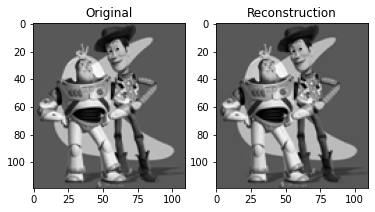

In [79]:
fig, axes = plt.subplots(1,2)

axes[0].set_title("Original")
axes[0].imshow(toy_img, cmap='gray')

axes[1].set_title("Reconstruction")
axes[1].imshow(recon_img)

In [80]:
im = Image.fromarray(np.clip(toy_img, 0.0, 255.0).astype('uint8'))
im.save("results/toy_original.png")
im = Image.fromarray(np.clip(recon_img, 0.0, 255.0).astype('uint8'))
im.save("results/toy_recon.png")

## Poisson Blending

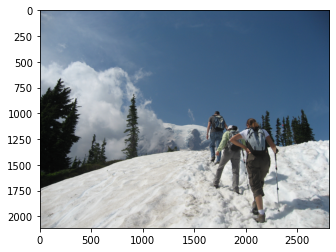

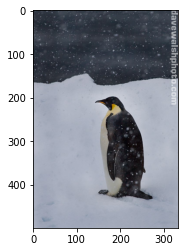

In [81]:
background_img = cv2.cvtColor(cv2.imread('data/hiking.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('data/penguin.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

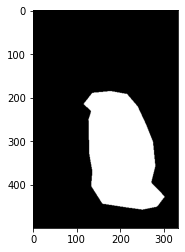

In [82]:
object_mask = np.load("data/penguin.npy")
plt.imshow(object_mask,cmap='gray')

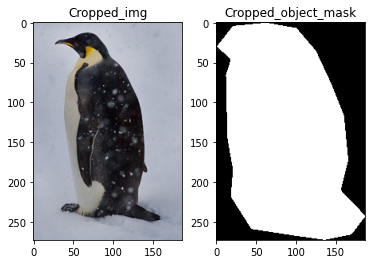

In [83]:
mask_y, mask_x = np.where(object_mask == 1)
(h,w) = object_mask.shape[:2]

cropped_object_mask = object_mask[min(mask_y)-1:max(mask_y)+1, min(mask_x)-1:max(mask_x)+1] # crop tightly
cropped_object_img = object_img[min(mask_y)-1:max(mask_y)+1, min(mask_x)-1:max(mask_x)+1,:]

fig, axes = plt.subplots(1,2)

axes[0].set_title("Cropped_img")
axes[0].imshow(cropped_object_img)

axes[1].set_title("Cropped_object_mask")
axes[1].imshow(cropped_object_mask, cmap='gray')

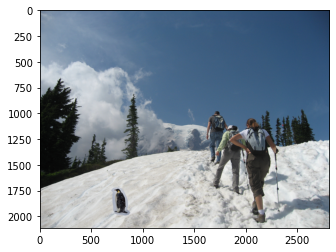

In [84]:
bottom_center = np.array([777, 1991])
bg_ul = upper_left_background_rc(cropped_object_mask, bottom_center)
plt.imshow(get_combined_img(background_img, cropped_object_img, cropped_object_mask, bg_ul))

In [85]:
def poisson_blend(src_img, trg_img, mask, h,w):
    A = scipy.sparse.lil_matrix((h*w,h*w), dtype='double')
    b = np.zeros((h*w, 1))
    e = 0
    im2var = np.arange(h*w).reshape(h,w)
    
    for y in range(0, h):
        for x in range(0, w):
            if mask[y,x] == 1:
                
                A[e, im2var[y][x]] = 4
                b[e] = 4*src_img[y][x]
                
                if x-1 >= 0:
                    A[e, im2var[y][x-1]] = -1
                    b[e] -= src_img[y][x-1]
                if x+1 < w:
                    A[e, im2var[y][x+1]] = -1
                    b[e] -= src_img[y][x+1]
                if y-1 >= 0:
                    A[e, im2var[y-1][x]] = -1
                    b[e] -= src_img[y-1][x]
                if y+1 < h:
                    A[e, im2var[y+1][x]] = -1
                    b[e] -= src_img[y+1][x]
                    
            else:
                A[e, im2var[y][x]] = 1
                b[e] = trg_img[y][x]
            e += 1
    
    v = scipy.sparse.linalg.lsqr(A.tocsc(), b)[0]
    return v.reshape((h,w))
        

0
1
2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


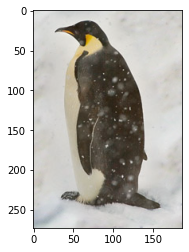

In [86]:
blend_im = np.zeros(cropped_object_img.shape)
h,w,c = cropped_object_img.shape
H,W,c = background_img.shape
cropped_background = background_img[bg_ul[0]:bg_ul[0]+h, bg_ul[1]:bg_ul[1]+w]

for i in range(c):
    print(i)
    im_i = poisson_blend(cropped_object_img[:,:,i].copy(), cropped_background[:,:,i].copy(), cropped_object_mask,
                        h,w)
    assert blend_im[:,:,i].shape == im_i.shape
    blend_im[:,:,i] = im_i

plt.imshow(blend_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


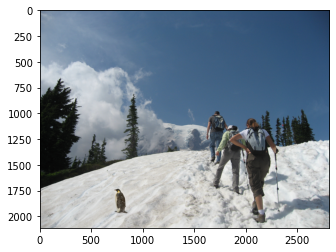

In [87]:
result_im = get_combined_img(background_img, blend_im, cropped_object_mask, bg_ul)
plt.imshow(result_im)

In [88]:
im = Image.fromarray(np.clip(result_im*255.0, 0.0, 255.0).astype('uint8'))
im.save("results/penguin.png")

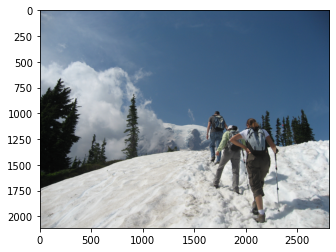

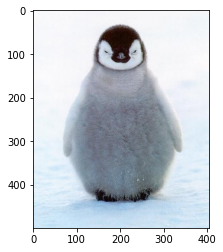

In [17]:
background_img = cv2.cvtColor(cv2.imread('data/hiking.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('data/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()


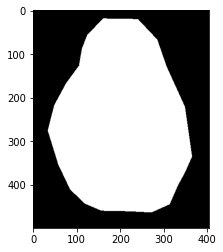

In [18]:
object_mask = np.load("data/penguin-chick.npy")
plt.imshow(object_mask,cmap='gray')

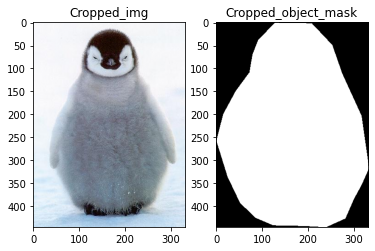

In [19]:
mask_y, mask_x = np.where(object_mask == 1)
(h,w) = object_mask.shape[:2]

cropped_object_mask = object_mask[min(mask_y)-1:max(mask_y)+1, min(mask_x)-1:max(mask_x)+1] # crop tightly
cropped_object_img = object_img[min(mask_y)-1:max(mask_y)+1, min(mask_x)-1:max(mask_x)+1,:]
# return object_img, object_mask
fig, axes = plt.subplots(1,2)

axes[0].set_title("Cropped_img")
axes[0].imshow(cropped_object_img)

axes[1].set_title("Cropped_object_mask")
axes[1].imshow(cropped_object_mask, cmap='gray')

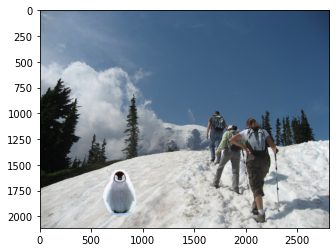

In [20]:
bottom_center = np.array([777, 1991])
bg_ul = upper_left_background_rc(cropped_object_mask, bottom_center)
plt.imshow(get_combined_img(background_img, cropped_object_img, cropped_object_mask, bg_ul))

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

blend_im = np.zeros(cropped_object_img.shape)
h,w,c = cropped_object_img.shape
H,W,c = background_img.shape
cropped_background = background_img[bg_ul[0]:bg_ul[0]+h, bg_ul[1]:bg_ul[1]+w]

for i in range(c):
    print(i)
    im_i = poisson_blend(cropped_object_img[:,:,i].copy(), cropped_background[:,:,i].copy(), cropped_object_mask,
                        h,w)
    assert blend_im[:,:,i].shape == im_i.shape
    blend_im[:,:,i] = im_i

#recon_img = Image.fromarray(v)

0
1
2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


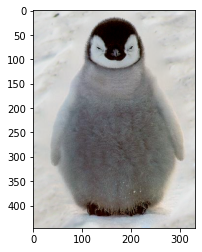

In [22]:
%matplotlib inline
plt.imshow(blend_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


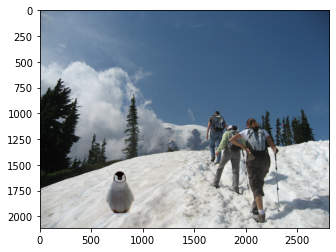

In [23]:
result_im = get_combined_img(background_img, blend_im, cropped_object_mask, bg_ul)
plt.imshow(result_im)

In [24]:
im = Image.fromarray(np.clip(result_im*255.0, 0.0, 255.0).astype('uint8'))
im.save("results/penguin_chick.png")

## Blending with mixed gradients

In [25]:
def mixed_gradient(b, src_img, trg_img, index, e):
    y,x = index
    neighbors = [(y+1,x), (y-1,x), (y, x+1), (y, x-1)]
    for i,j in neighbors:
        src_grad = 0.0
        trg_grad = 0.0
        try:
            src_grad = src_img[y][x] - src_img[i][j]
            trg_grad = trg_img[y][x] - trg_img[i][j]
        except:
            continue
        if abs(src_grad) > abs(trg_grad):
            b[e] += src_grad
        else:
            b[e] += trg_grad
    return b
    

In [26]:
def poisson_blend_mixed(src_img, trg_img, mask, h,w):
    A = scipy.sparse.lil_matrix((h*w,h*w), dtype='double')
    b = np.zeros((h*w, 1))
    e = 0
    im2var = np.arange(h*w).reshape(h,w)
    
    for y in range(0, h):
        for x in range(0, w):
            if mask[y,x] == 1:
                
                A[e, im2var[y][x]] = 4
                
                if x-1 >= 0:
                    A[e, im2var[y][x-1]] = -1
                if x+1 < w:
                    A[e, im2var[y][x+1]] = -1
                if y-1 >= 0:
                    A[e, im2var[y-1][x]] = -1
                if y+1 < h:
                    A[e, im2var[y+1][x]] = -1
                
                b = mixed_gradient(b, src_img, trg_img, (y,x), e)
                    
            else:
                A[e, im2var[y][x]] = 1
                b[e] = trg_img[y][x]
            e += 1
    
    v = scipy.sparse.linalg.lsqr(A.tocsc(), b)[0]
    return v.reshape((h,w))

0
1
2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


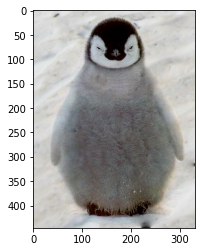

In [27]:
blend_im_mixed = np.zeros(cropped_object_img.shape)
h,w,c = cropped_object_img.shape
H,W,c = background_img.shape
cropped_background = background_img[bg_ul[0]:bg_ul[0]+h, bg_ul[1]:bg_ul[1]+w]

for i in range(c):
    print(i)
    im_i = poisson_blend_mixed(cropped_object_img[:,:,i].copy(), cropped_background[:,:,i].copy(), cropped_object_mask,
                        h,w)
    assert blend_im_mixed[:,:,i].shape == im_i.shape
    blend_im_mixed[:,:,i] = im_i

plt.imshow(blend_im_mixed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


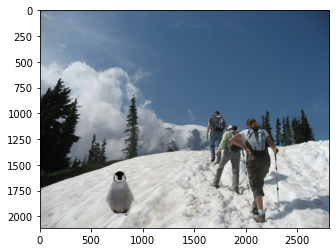

In [28]:
result_im = get_combined_img(background_img, blend_im_mixed, cropped_object_mask, bg_ul)
plt.imshow(result_im)

In [29]:
im = Image.fromarray(np.clip(result_im*255.0, 0.0, 255.0).astype('uint8'))
im.save("results/penguin_chick_mixed.png")

## Your own examples

### Example 1

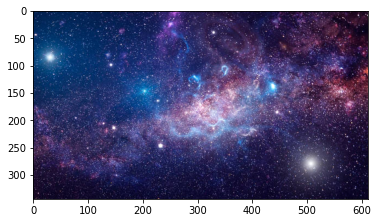

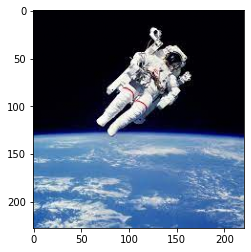

In [30]:
bottom_center = np.array([175, 170])
object_mask = np.load("data/astronaut.npy")
background_img = cv2.cvtColor(cv2.imread('data/space.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('data/astronaut.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

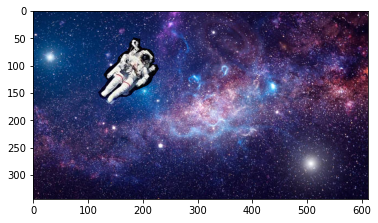

In [31]:
mask_y, mask_x = np.where(object_mask == 1)
(h,w) = object_mask.shape[:2]

cropped_object_mask = object_mask[min(mask_y)-1:max(mask_y)+1, min(mask_x)-1:max(mask_x)+1] # crop tightly
cropped_object_img = object_img[min(mask_y)-1:max(mask_y)+1, min(mask_x)-1:max(mask_x)+1,:]

bg_ul = upper_left_background_rc(cropped_object_mask, bottom_center)
plt.imshow(get_combined_img(background_img, cropped_object_img, cropped_object_mask, bg_ul))

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

blend_im = np.zeros(cropped_object_img.shape)
blend_im_mixed = np.zeros(cropped_object_img.shape)
h,w,c = cropped_object_img.shape
H,W,c = background_img.shape
cropped_background = background_img[bg_ul[0]:bg_ul[0]+h, bg_ul[1]:bg_ul[1]+w]

for i in range(c):
    print(i)
    im_i = poisson_blend(cropped_object_img[:,:,i].copy(), cropped_background[:,:,i].copy(), cropped_object_mask,
                        h,w)
    im_i_mix = poisson_blend_mixed(cropped_object_img[:,:,i].copy(), cropped_background[:,:,i].copy(), cropped_object_mask,
                        h,w)
    assert blend_im[:,:,i].shape == im_i.shape
    assert blend_im_mixed[:,:,i].shape == im_i_mix.shape
    blend_im[:,:,i] = im_i
    blend_im_mixed[:,:,i] = im_i_mix


result_blend = get_combined_img(background_img, blend_im, cropped_object_mask, bg_ul)
result_blend_mixed = get_combined_img(background_img, blend_im_mixed, cropped_object_mask, bg_ul)

0
1
2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


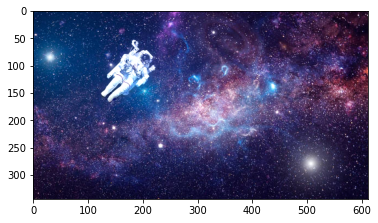

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


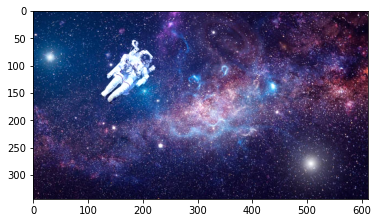

In [33]:
plt.figure()
plt.imshow(result_blend)
plt.show()
plt.imshow(result_blend_mixed)
plt.show()

In [34]:
im = Image.fromarray(np.clip(result_blend*255.0, 0.0, 255.0).astype('uint8'))
im.save("results/astronaut_space.png")
im = Image.fromarray(np.clip(result_blend_mixed*255.0, 0.0, 255.0).astype('uint8'))
im.save("results/astronaut_space_mixed.png")

### Example 2

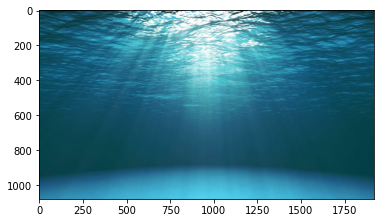

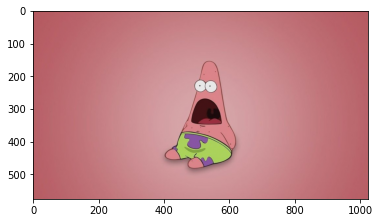

In [89]:
bottom_center = np.array([971, 1000])
object_mask = np.load("data/patrick.npy")
background_img = cv2.cvtColor(cv2.imread('data/underwater.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('data/patrick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

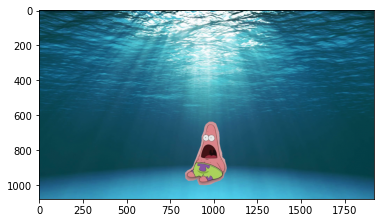

In [90]:
mask_y, mask_x = np.where(object_mask == 1)
(h,w) = object_mask.shape[:2]

cropped_object_mask = object_mask[min(mask_y)-1:max(mask_y)+1, min(mask_x)-1:max(mask_x)+1] # crop tightly
cropped_object_img = object_img[min(mask_y)-1:max(mask_y)+1, min(mask_x)-1:max(mask_x)+1,:]

bg_ul = upper_left_background_rc(cropped_object_mask, bottom_center)
plt.imshow(get_combined_img(background_img, cropped_object_img, cropped_object_mask, bg_ul))

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline

blend_im = np.zeros(cropped_object_img.shape)
blend_im_mixed = np.zeros(cropped_object_img.shape)
h,w,c = cropped_object_img.shape
H,W,c = background_img.shape
cropped_background = background_img[bg_ul[0]:bg_ul[0]+h, bg_ul[1]:bg_ul[1]+w]

for i in range(c):
    print(i)
    im_i = poisson_blend(cropped_object_img[:,:,i].copy(), cropped_background[:,:,i].copy(), cropped_object_mask,
                        h,w)
    im_i_mix = poisson_blend_mixed(cropped_object_img[:,:,i].copy(), cropped_background[:,:,i].copy(), cropped_object_mask,
                        h,w)
    assert blend_im[:,:,i].shape == im_i.shape
    assert blend_im_mixed[:,:,i].shape == im_i_mix.shape
    blend_im[:,:,i] = im_i
    blend_im_mixed[:,:,i] = im_i_mix


result_blend = get_combined_img(background_img, blend_im, cropped_object_mask, bg_ul)
result_blend_mixed = get_combined_img(background_img, blend_im_mixed, cropped_object_mask, bg_ul)

0
1
2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


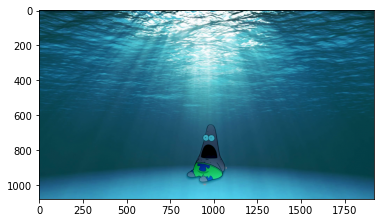

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


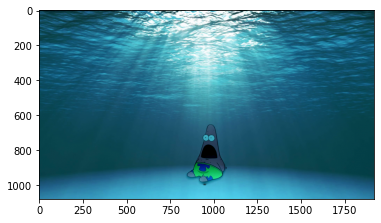

In [92]:
plt.figure()
plt.imshow(result_blend)
plt.show()
plt.imshow(result_blend_mixed)
plt.show()

In [93]:
im = Image.fromarray(np.clip(result_blend*255.0, 0.0, 255.0).astype('uint8'))
im.save("results/patrick_underwater.png")
im = Image.fromarray(np.clip(result_blend_mixed*255.0, 0.0, 255.0).astype('uint8'))
im.save("results/patrick_underwater_mixed.png")

### Example 3

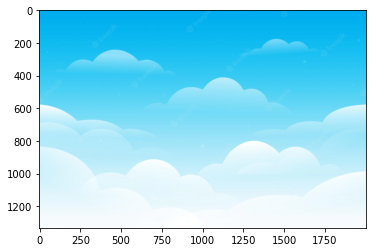

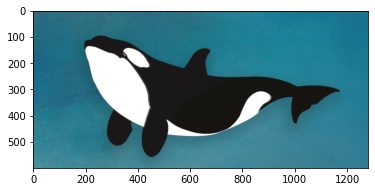

In [47]:
bottom_center = np.array([959, 667])
object_mask = np.load("data/whale.npy")
background_img = cv2.cvtColor(cv2.imread('data/sky.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('data/whale.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

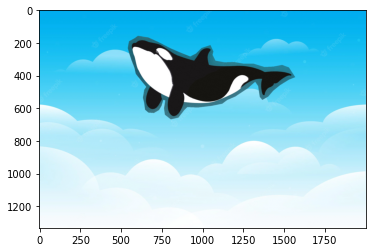

In [48]:
mask_y, mask_x = np.where(object_mask == 1)
(h,w) = object_mask.shape[:2]

cropped_object_mask = object_mask[min(mask_y)-1:max(mask_y)+1, min(mask_x)-1:max(mask_x)+1] # crop tightly
cropped_object_img = object_img[min(mask_y)-1:max(mask_y)+1, min(mask_x)-1:max(mask_x)+1,:]

bg_ul = upper_left_background_rc(cropped_object_mask, bottom_center)
plt.imshow(get_combined_img(background_img, cropped_object_img, cropped_object_mask, bg_ul))

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

blend_im = np.zeros(cropped_object_img.shape)
blend_im_mixed = np.zeros(cropped_object_img.shape)
h,w,c = cropped_object_img.shape
H,W,c = background_img.shape
cropped_background = background_img[bg_ul[0]:bg_ul[0]+h, bg_ul[1]:bg_ul[1]+w]

for i in range(c):
    print(i)
    im_i = poisson_blend(cropped_object_img[:,:,i].copy(), cropped_background[:,:,i].copy(), cropped_object_mask,
                        h,w)
    im_i_mix = poisson_blend_mixed(cropped_object_img[:,:,i].copy(), cropped_background[:,:,i].copy(), cropped_object_mask,
                        h,w)
    assert blend_im[:,:,i].shape == im_i.shape
    assert blend_im_mixed[:,:,i].shape == im_i_mix.shape
    blend_im[:,:,i] = im_i
    blend_im_mixed[:,:,i] = im_i_mix


result_blend = get_combined_img(background_img, blend_im, cropped_object_mask, bg_ul)
result_blend_mixed = get_combined_img(background_img, blend_im_mixed, cropped_object_mask, bg_ul)

0
1
2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


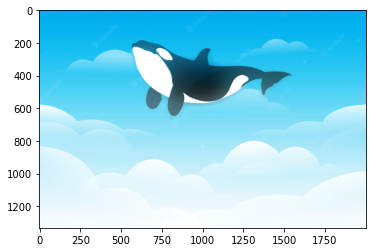

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


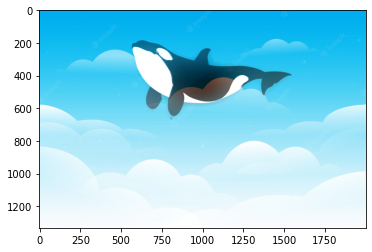

In [50]:
plt.figure()
plt.imshow(result_blend)
plt.show()
plt.imshow(result_blend_mixed)
plt.show()

In [52]:
im = Image.fromarray(np.clip(result_blend*255.0, 0.0, 255.0).astype('uint8'))
im.save("results/whale_sky.png")
im = Image.fromarray(np.clip(result_blend_mixed*255.0, 0.0, 255.0).astype('uint8'))
im.save("results/whale_sky_mixed.png")